In [220]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from jinja2.environment import copy_cache
from matplotlib.colors import LogNorm
from matplotlib.pyplot import fill_between
from scipy.signal import stft
import zarr
from statsmodels.sandbox.distributions.try_pot import mean_residual_life

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm

In [222]:
import scienceplots
plt.style.use('science')
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[T1]{fontenc} \usepackage{polski} \usepackage[utf8]{inputenc}'
})
figsize = (6, 3)
linewidth = 0.5
linewidth_time_series = 0.3

In [223]:
shot_data = requests.get("https://mastapp.site/json/shots/30421").json()
endpoint, url = shot_data["endpoint_url"], shot_data["url"]
shot_url = url.replace("s3:/", endpoint)

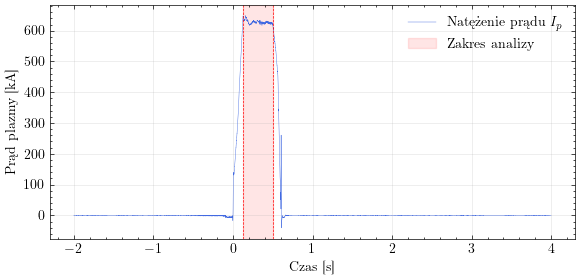

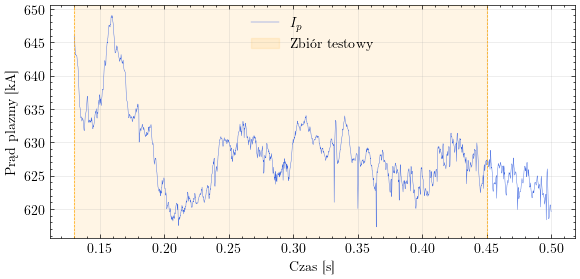

In [224]:
dataset = xr.open_zarr(shot_url, group='amc', storage_options={'ssl': False})
# dataset = dataset.isel(time=(dataset.time > 0) & (dataset.time < .35))
dataset = dataset.isel()
ts_full = dataset['plasma_current'].to_series()

start_cut = 0.13
end_cut = 0.5
test_end_cut = 0.45
mast_data_full = ts_full[(ts_full.index > start_cut) & (ts_full.index < end_cut)]
mast_data = ts_full[(ts_full.index > start_cut) & (ts_full.index < test_end_cut)]

# RYSUNEK 1: Cały przebieg z zaznaczonym wycinkiem
plt.figure(figsize=figsize)
plt.plot(dataset['time'], dataset['plasma_current'], label='Natężenie prądu $I_p$', color='royalblue', linewidth=linewidth_time_series)

plt.axvline(x=start_cut, color='red', linestyle='--', linewidth=linewidth)
plt.axvline(x=end_cut, color='red', linestyle='--', linewidth=linewidth)
plt.axvspan(start_cut, end_cut, color='red', alpha=0.1, label='Zakres analizy')

plt.xlabel("Czas [s]")
plt.ylabel("Prąd plazmy [kA]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/figure1.pdf")
plt.show()

# RYSUNEK 2: Tylko ten wycinek ze zbiorem testowym (mast_data)
plt.figure(figsize=figsize)
plt.plot(mast_data_full, color='royalblue', linewidth=linewidth_time_series, label='$I_p$')

plt.axvline(x=start_cut, color='orange', linestyle='--', linewidth=linewidth)
plt.axvline(x=test_end_cut, color='orange', linestyle='--', linewidth=linewidth)
plt.axvspan(start_cut, test_end_cut, color='orange', alpha=0.1, label='Zbiór testowy')

plt.xlabel("Czas [s]")
plt.ylabel("Prąd plazmy [kA]")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("latex/figures/figure2.pdf")
plt.show()


---
# ACF, PACF
---

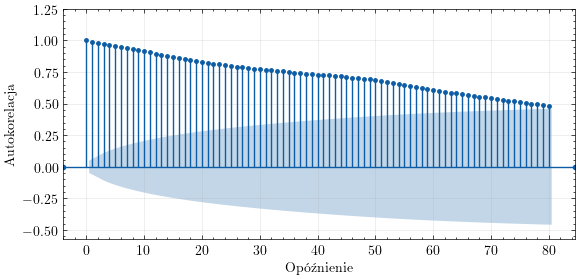

In [225]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

plot_acf(mast_data, lags=80, ax=ax, marker=".", auto_ylims=True)
ax.set_xlabel('Opóźnienie')
ax.set_ylabel('Autokorelacja')
ax.set_title('')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/empiryczna_acf_surowe.pdf")


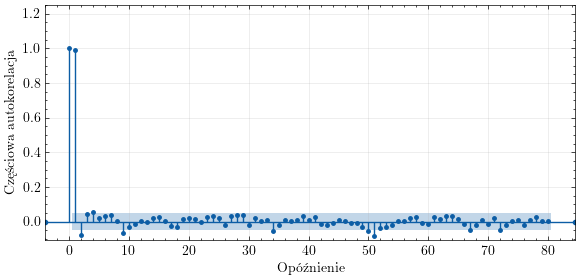

In [226]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

plot_pacf(mast_data, lags=80, ax=ax, marker=".", auto_ylims=True)
ax.set_xlabel('Opóźnienie')
ax.set_ylabel('Częściowa autokorelacja')
ax.set_title('')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/empiryczna_pacf_surowe.pdf")


---
# test ADF
---

In [227]:
def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1], 3)
    stats   = round(res[0], 3)

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

adfuller_test(mast_data)

Statystyka testowa = -2.98, p-Value = 0.037 => Stationary. 


---
# dekompozycja
---

### Różnicowanie

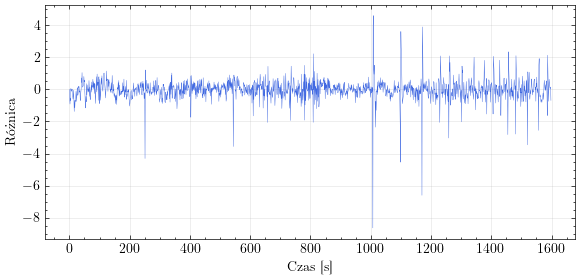

In [228]:
ts_analysis = np.diff(mast_data)

fig = plt.figure(figsize=figsize)

plt.plot(ts_analysis, color='royalblue', linewidth=linewidth_time_series)
plt.xlabel("Czas [s]")
plt.ylabel("Różnica")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/dekompozycja.pdf")

plt.show()


---
# wykresy acf, pacf dla uzyskanego szeregu
---

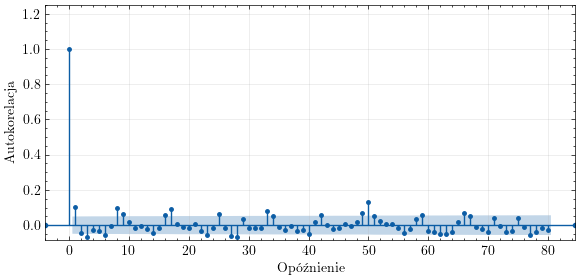

In [229]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

plot_acf(ts_analysis, lags=80, ax=ax, marker=".", auto_ylims=True)
ax.set_xlabel('Opóźnienie')
ax.set_ylabel('Autokorelacja')
ax.set_title('')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/empiryczna_acf_po_dekompozycji.pdf")


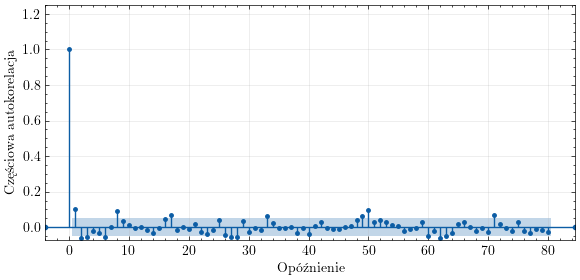

In [230]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

plot_pacf(ts_analysis, lags=80, ax=ax, marker=".", auto_ylims=True)
ax.set_xlabel('Opóźnienie')
ax.set_ylabel('Częściowa autokorelacja')
ax.set_title('')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/empiryczna_pacf_po_dekompozycji.pdf")


---
# test ADF
---

In [231]:
adfuller_test(ts_analysis)

Statystyka testowa = -14.148, p-Value = 0.0 => Stationary. 


---
# modelowanie ARMA
---

Wyniki:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1599
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1597.319
Date:                Thu, 29 Jan 2026   AIC                           3202.637
Time:                        21:06:26   BIC                           3224.146
Sample:                             0   HQIC                          3210.624
                               - 1599                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0121      0.021     -0.565      0.572      -0.054       0.030
ar.L1         -0.1449      0.098     -1.486      0.137      -0.336       0.046
ma.L1          0.2556      0.093      2.735 

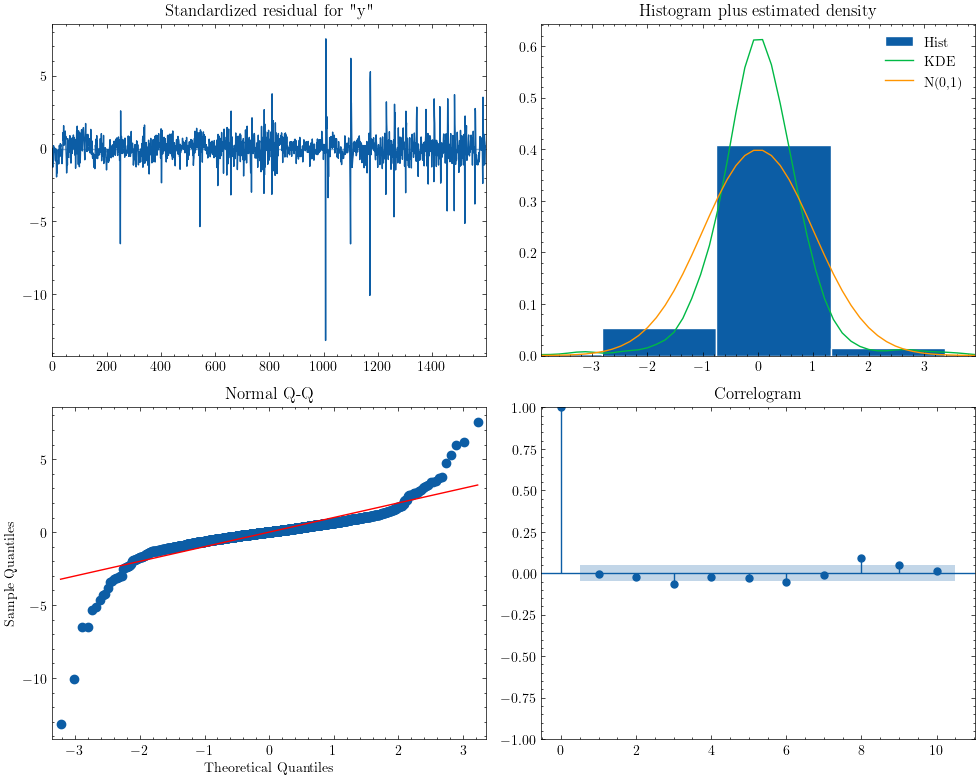

In [232]:
# model z szumem z rozkładu normalnego

p, q = 1, 1  # wysoka acv i niska pacv??

model = ARIMA(ts_analysis, order=(p, 0, q)).fit(method='innovations_mle')

print("Wyniki:")
print(model.summary())

model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

In [233]:
"""import pmdarima as pm

# Model z automatu
auto_model = pm.auto_arima(ts_analysis,
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=5,
                       max_q=5,
                       max_order=None,
                       trace=True,
                       seasonal=False,
                       stepwise = False)

print(auto_model.summary())"""

'import pmdarima as pm\n\n# Model z automatu\nauto_model = pm.auto_arima(ts_analysis,\n                       d=0,\n                       start_p=0,\n                       start_q=0,\n                       max_d=0,\n                       max_p=5,\n                       max_q=5,\n                       max_order=None,\n                       trace=True,\n                       seasonal=False,\n                       stepwise = False)\n\nprint(auto_model.summary())'

In [234]:
# model z szumem z rozkładu t Studenta

p, q = 1, 1

model_first_method = ARIMA(ts_analysis, order=(p, 0, q)).fit(method='statespace')
model_second_method = ARIMA(ts_analysis, order=(p, 0, q)).fit(method='innovations_mle')
model_third_method = ARIMA(ts_analysis, order=(p, 0, q)).fit(method='hannan_rissanen')

print("Wyniki dla method='statespace':\n")
print(model_first_method.summary())
print("\n")
print("Wyniki dla method='innovations_mle':\n")
print(model_second_method.summary())
print("\n")
print("Wyniki dla method='hannan_rissanen':\n")
print(model_third_method.summary())

Wyniki dla method='statespace':

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1599
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1597.319
Date:                Thu, 29 Jan 2026   AIC                           3202.637
Time:                        21:06:26   BIC                           3224.146
Sample:                             0   HQIC                          3210.624
                               - 1599                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0121      0.021     -0.565      0.572      -0.054       0.030
ar.L1         -0.1448      0.098     -1.485      0.138      -0.336       0.046
ma.L1          0.25

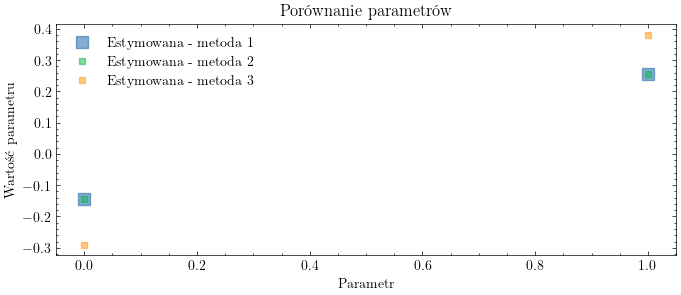

In [235]:
plt.figure(figsize=(8,3))

plt.plot(model_first_method.params[1:-1], 's', markersize=8, alpha=0.5, label='Estymowana - metoda 1')
plt.plot(model_second_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 2')
plt.plot(model_third_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 3')
plt.legend()
plt.xlabel('Parametr')
plt.ylabel('Wartość parametru')
plt.title('Porównanie parametrów')

plt.show()

---
# Ocena dopasowania modelu
---

<>:62: SyntaxWarning: invalid escape sequence '\%'
<>:62: SyntaxWarning: invalid escape sequence '\%'
/var/folders/md/bjv2qqp906q0tvtbwsrkfkw00000gn/T/ipykernel_47554/2421937582.py:62: SyntaxWarning: invalid escape sequence '\%'
  color='red', alpha=0.2, label='Przedział ufności 95\%')
/Users/nikodem/Desktop/github/raport-szeregi-czasowe/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


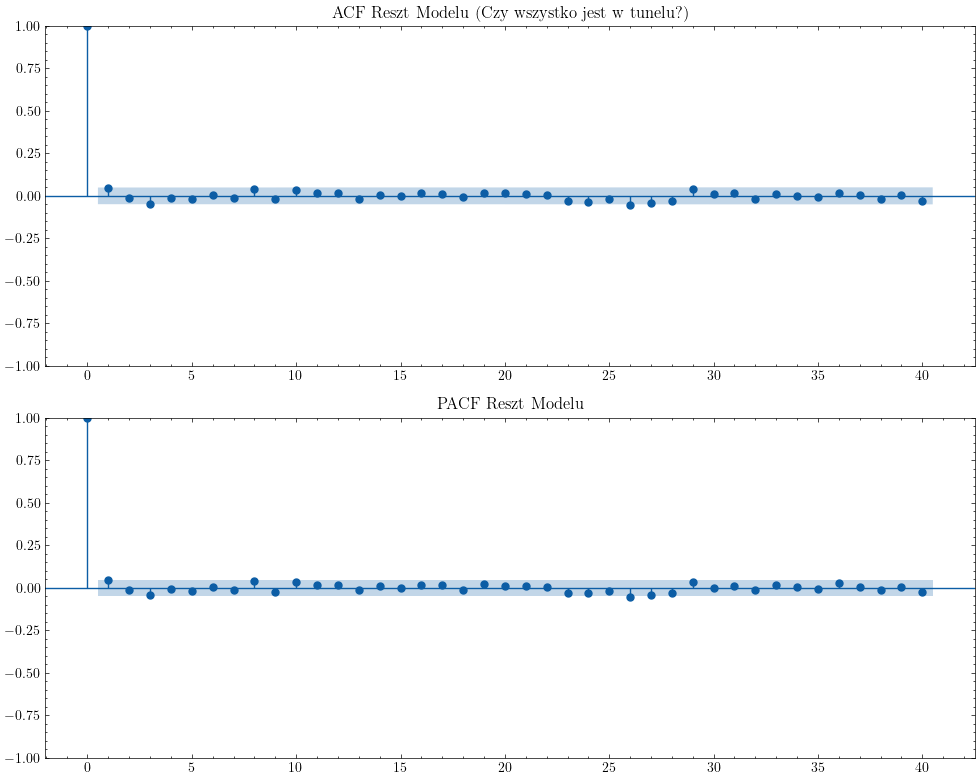

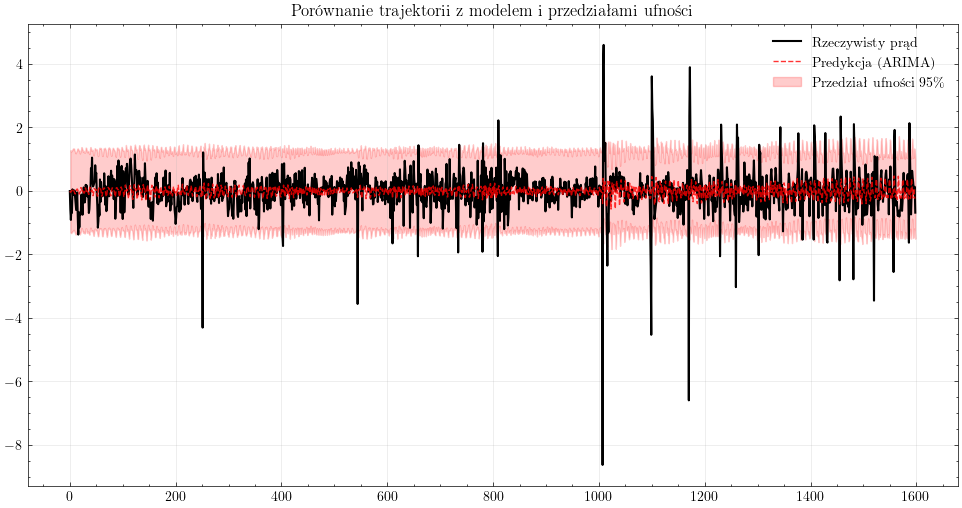

0.965603502188868


In [236]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


raw_data = ts_analysis
model = ARIMA(raw_data, order=(5, 0, 5))
model_fit = model.fit()

# diagnostyka reszt
residuals = model_fit.resid
resid_to_plot = residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Wykres ACF reszt (Autokorelacja)
# alpha=0.05 rysuje niebieski obszar (przedział ufności 95%)
plot_acf(resid_to_plot, ax=ax1, lags=40, title='ACF Reszt Modelu (Czy wszystko jest w tunelu?)', alpha=0.05)

# Wykres PACF reszt
plot_pacf(resid_to_plot, ax=ax2, lags=40, title='PACF Reszt Modelu', alpha=0.05)

plt.tight_layout()
plt.show()

# trajektoria i linie kwanylowe

# Pobieramy predykcję
pred_results = model_fit.get_prediction(start=1, dynamic=False)
pred_mean = pred_results.predicted_mean

# Przedziały ufności (zwraca macierz NumPy)
pred_conf = pred_results.conf_int(alpha=0.05)

lower_bound = pred_conf[:, 0]
upper_bound = pred_conf[:, 1]

plt.figure(figsize=(12, 6))


raw_values = raw_data if isinstance(raw_data, np.ndarray) else raw_data.values

plt.plot(raw_values, label='Rzeczywisty prąd', color='black', linewidth=1.5)
plt.plot(pred_mean, label='Predykcja (ARIMA)', color='red', linestyle='--', alpha=0.8)

# Rura (Fill Between)
# Uwaga: Musimy upewnić się, że oś X (indeksy) pasuje do długości predykcji
# get_prediction(start=1) zwraca wynik krótszy o 1 od oryginału (jeśli liczymy od 0)
# Najbezpieczniej użyć range() dla osi X
x_axis = range(1, len(raw_values)) # Indeksy od 1 do końca

# Jeśli pred_mean jest krótsze (zależy od wersji statsmodels), dopasujmy x_axis
if len(pred_mean) == len(raw_values):
    # Czasem prediction zwraca też dla indeksu 0
    x_axis = range(len(raw_values))
elif len(pred_mean) == len(raw_values) - 1:
    x_axis = range(1, len(raw_values))

plt.fill_between(x_axis,
                 lower_bound,
                 upper_bound,
                 color='red', alpha=0.2, label='Przedział ufności 95\%')

plt.title('Porównanie trajektorii z modelem i przedziałami ufności')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

count = 0
i = 0
for i in range(len(raw_values)-1):
    if lower_bound[i] < raw_values[i] < upper_bound[i]:
        count += 1

print(count/len(raw_values))

### prognoza dla przyszlosci i porownanie

Liczba kroków do przewidzenia (różnic): 250


<>:45: SyntaxWarning: invalid escape sequence '\%'
<>:45: SyntaxWarning: invalid escape sequence '\%'
/var/folders/md/bjv2qqp906q0tvtbwsrkfkw00000gn/T/ipykernel_47554/126933700.py:45: SyntaxWarning: invalid escape sequence '\%'
  color='red', alpha=0.15, label='95\% Przedział Ufności')


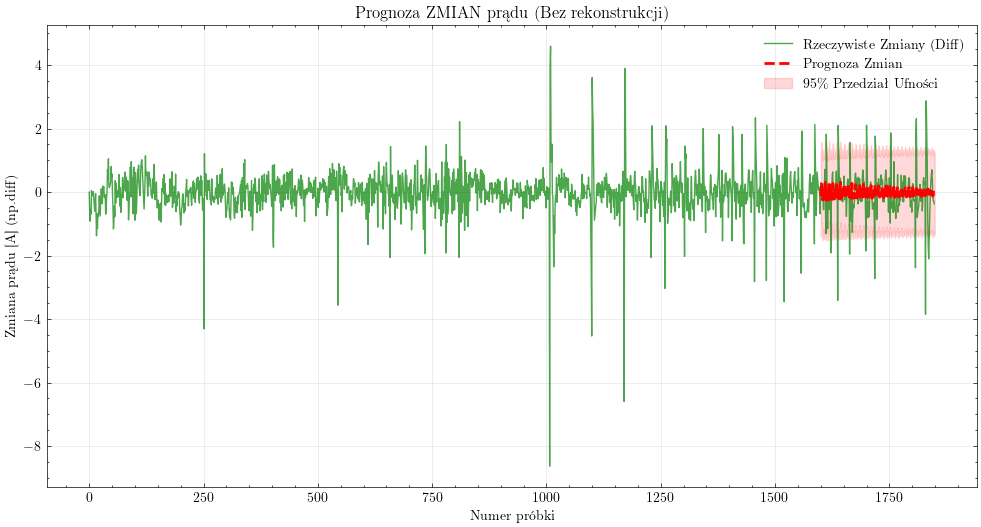

Błąd średniokwadratowy (RMSE) dla różnic: 0.7751


In [237]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

n_train = len(mast_data)
# Bierzemy dane testowe + 1 punkt wstecz (żeby policzyć pierwszą różnicę)
raw_test_data = mast_data_full.iloc[n_train-1:]

# Skoro model przewiduje różnice, musimy porównać je z rzeczywistymi różnicami
real_diffs = np.diff(raw_test_data.values) # To jest nasza "płyta wzorcowa"
n_forecast = len(real_diffs)

print(f"Liczba kroków do przewidzenia (różnic): {n_forecast}")

forecast_result = model_fit.get_forecast(steps=n_forecast)

# Pobieramy same wartości (zmiany)
predicted_diffs = forecast_result.predicted_mean
if isinstance(predicted_diffs, pd.Series):
    predicted_diffs = predicted_diffs.values

# Pobieramy przedziały ufności
conf_int = forecast_result.conf_int(alpha=0.05)
if isinstance(conf_int, pd.DataFrame):
    conf_int = conf_int.values


plt.figure(figsize=(12, 6))

x_axis = range(n_train, n_train + n_forecast)
ts_full = np.concatenate((ts_analysis, real_diffs))

# A. Rzeczywiste zmiany (Zielone)
plt.plot(ts_full,
         color='green', label='Rzeczywiste Zmiany (Diff)', alpha=0.7)

# B. Prognozowane zmiany (Czerwone)
plt.plot(x_axis, predicted_diffs,
         color='red', linestyle='--', label='Prognoza Zmian', linewidth=2)


plt.fill_between(x_axis,
                 conf_int[:, 0],
                 conf_int[:, 1],
                 color='red', alpha=0.15, label='95\% Przedział Ufności')

plt.title('Prognoza ZMIAN prądu (Bez rekonstrukcji)')
plt.xlabel('Numer próbki')
plt.ylabel('Zmiana prądu [A] (np.diff)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. OCENA BŁĘDU
mse = np.mean((real_diffs - predicted_diffs)**2)
print(f"Błąd średniokwadratowy (RMSE) dla różnic: {np.sqrt(mse):.4f}")

---
# wyryfgikacja zalozen dot. szumu
---

=== RAPORT DIAGNOSTYCZNY RESZT ===

1. Test Średniej (T-test):
   Średnia reszt: -1.2344e-03
   P-value: 0.9389
   ✅ WNIOSEK: Brak podstaw do odrzucenia H0. Średnia jest równa 0.

2. Test Wariancji (ARCH Test):
   P-value: 0.0000
   ⚠️ WNIOSEK: Wykryto zmienną wariancję (efekt ARCH).

3. Test Niezależności (Ljung-Box, lag=10):
   P-value: 0.2137
   ✅ WNIOSEK: Reszty są niezależne (brak autokorelacji, biały szum).

4. Test Normalności (Jarque-Bera):
   P-value: 0.0000
   ⚠️ WNIOSEK: Rozkład nie jest idealnie normalny (częste w danych fizycznych).


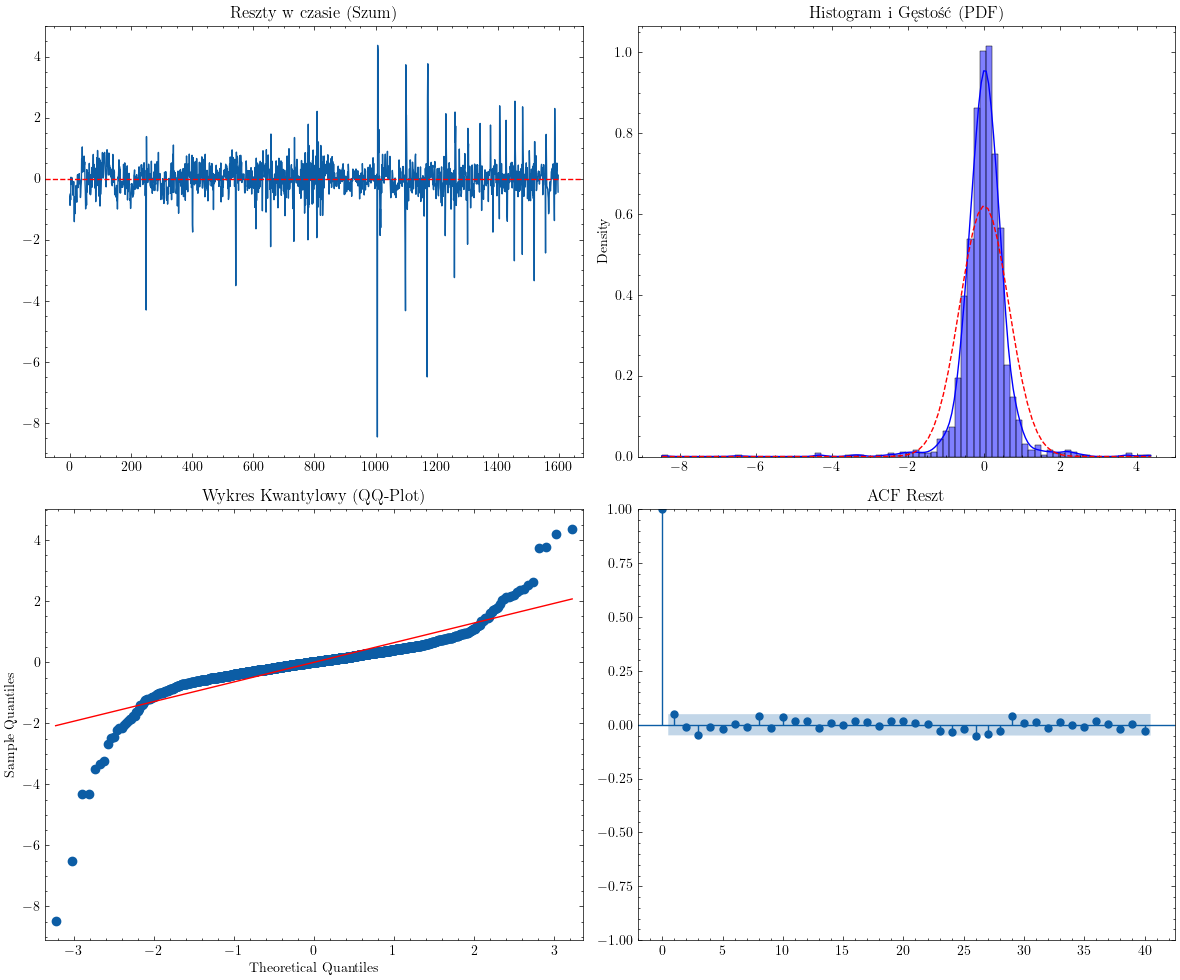

In [238]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot

# 1. Pobieramy reszty i czyścimy
# Pomijamy pierwszą resztę (często 0 lub nan przy różnicowaniu)
residuals = model_fit.resid[1:]

# Czasami w środku mogą być NaN, warto usunąć dla bezpieczeństwa testów
residuals = residuals[~np.isnan(residuals)]

print("=== RAPORT DIAGNOSTYCZNY RESZT ===")

# ==============================================================================
# 1. ZAŁOŻENIE O ŚREDNIEJ (Czy średnia reszt = 0?)
# ==============================================================================
mean_val = np.mean(residuals)
t_stat, p_val_mean = stats.ttest_1samp(residuals, 0)

print(f"\n1. Test Średniej (T-test):")
print(f"   Średnia reszt: {mean_val:.4e}") # notacja naukowa
print(f"   P-value: {p_val_mean:.4f}")
if p_val_mean > 0.05:
    print("   ✅ WNIOSEK: Brak podstaw do odrzucenia H0. Średnia jest równa 0.")
else:
    print("   ⚠️ WNIOSEK: Średnia istotnie różna od 0 (może potrzebny stały wyraz w modelu?)")

# ==============================================================================
# 2. ZAŁOŻENIE O WARIANCJI (Czy wariancja jest stała? - Homoscedastyczność)
# Używamy testu ARCH (Engle's Test) - standard w szeregach czasowych
# ==============================================================================
# H0: Brak efektu ARCH (wariancja jest stała, sam szum)
# H1: Występuje efekt ARCH (wariancja zmienia się w czasie / klastrowanie zmienności)
test_arch = het_arch(residuals)
p_val_arch = test_arch[1] # p-value dla Lagrange Multiplier test

print(f"\n2. Test Wariancji (ARCH Test):")
print(f"   P-value: {p_val_arch:.4f}")
if p_val_arch > 0.05:
    print("   ✅ WNIOSEK: Wariancja jest stała (szum jednorodny).")
else:
    print("   ⚠️ WNIOSEK: Wykryto zmienną wariancję (efekt ARCH).")

# ==============================================================================
# 3. ZAŁOŻENIE O NIEZALEŻNOŚCI (Czy brak autokorelacji?)
# Test Ljunga-Boxa
# ==============================================================================
# Sprawdzamy np. dla opóźnienia 10
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
p_val_lb = lb_test['lb_pvalue'].values[0]

print(f"\n3. Test Niezależności (Ljung-Box, lag=10):")
print(f"   P-value: {p_val_lb:.4f}")
if p_val_lb > 0.05:
    print("   ✅ WNIOSEK: Reszty są niezależne (brak autokorelacji, biały szum).")
else:
    print("   ⚠️ WNIOSEK: Istnieje autokorelacja w resztach (model czegoś nie wyłapał).")

# ==============================================================================
# 4. ZAŁOŻENIE O NORMALNOŚCI ROZKŁADU
# Test Jarque-Bera (dobry dla dużych próbek)
# ==============================================================================
jb_stat, p_val_norm = stats.jarque_bera(residuals)

print(f"\n4. Test Normalności (Jarque-Bera):")
print(f"   P-value: {p_val_norm:.4f}")
if p_val_norm > 0.05:
    print("   ✅ WNIOSEK: Rozkład reszt jest normalny.")
else:
    print("   ⚠️ WNIOSEK: Rozkład nie jest idealnie normalny (częste w danych fizycznych).")

# ==============================================================================
# WIZUALIZACJA (Wykresy wymagane przez prowadzącego)
# ==============================================================================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# A. Wykres reszt w czasie (Weryfikacja wizualna średniej i wariancji)
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Reszty w czasie (Szum)')
axes[0, 0].axhline(0, color='red', linestyle='--')

# B. Histogram i Gęstość (PDF)
import seaborn as sns # Opcjonalnie, jeśli masz. Jak nie, użyj plt.hist
try:
    sns.histplot(residuals, kde=True, ax=axes[0, 1], color='blue', stat="density")
    # Rysujemy idealną krzywą Gaussa dla porównania
    x = np.linspace(min(residuals), max(residuals), 100)
    axes[0, 1].plot(x, stats.norm.pdf(x, mean_val, np.std(residuals)), 'r--', label='Idealny Gauss')
    axes[0, 1].set_title('Histogram i Gęstość (PDF)')
except:
    axes[0, 1].hist(residuals, bins=50, density=True, alpha=0.6)
    axes[0, 1].set_title('Histogram')

# C. QQ-Plot (Weryfikacja ogonów rozkładu)
qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Wykres Kwantylowy (QQ-Plot)')

# D. ACF Reszt (Powtórzenie dla pewności)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, ax=axes[1, 1], lags=40, title='ACF Reszt', alpha=0.05)

plt.tight_layout()
plt.show()